In [4]:
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
import sys
print(sys.version)

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]


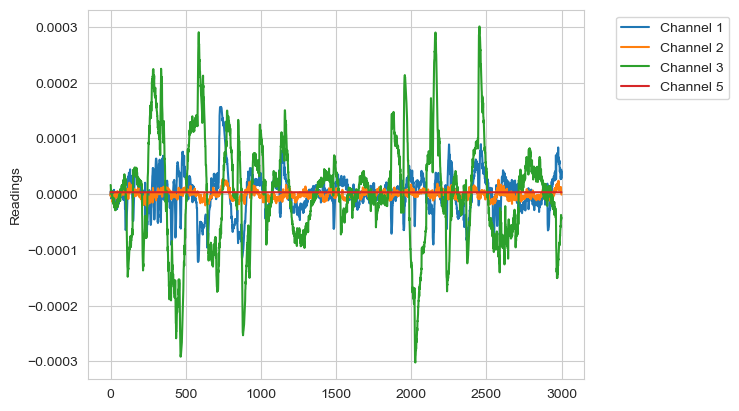

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_epoch(file, epoch):
    x = np.load(file)
    for i in range(x.shape[1]):
        if i == 3 or i == 5:
            continue
        arr = x[epoch][i]
        df = pd.DataFrame({'Readings': arr})
        sns.lineplot(data=df['Readings'], label=f'Channel {i + 1}')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
plot_epoch('Training/p00_n1_NEW_X.npy', 0)

In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU, BatchNormalization, Conv1D, Bidirectional
from sklearn.preprocessing import MinMaxScaler

In [71]:
def batch_data(source_dir):
    # load data
    data = [np.load(f"{source_dir}/{filename}") for filename in sorted(os.listdir(source_dir))]
    x, y = data[0], data[1]
    for i in range(2, len(data), 2):
        x = np.concatenate((x, data[i]))
        y = np.concatenate((y, data[i+1]))

    y = np.where(y == 0, np.nan, y)

    indices = np.where(y == 1)[0]
    start = int(len(indices) * 0.35)
    end = len(indices) - start

    y[indices[:start]] = np.nan
    y[indices[end:]] = np.nan

    # Remove NaN values
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)].astype(int)
        
    # x1 = np.copy(x)
    # for i in range(1,6):
    #     x = np.concatenate((np.concatenate((np.zeros((i, x1.shape[1], x1.shape[2])), x1[:-i, :, :])), x), axis=2)
    # print(x.shape)

    # Create a new array by removing 0 and 1 states
    
    x = x[:, [0,1, 2,3, 4, 5], :]
    
    prevState = np.array([[[0.01 * t for t in range(3000)]] for i in range(x.shape[0])])
    print(prevState.shape)
    x = np.concatenate((x, prevState), axis=1)

    new_y = np.zeros((y.shape[0], 6))
    for i in range(len(y)):
        new_y[i, y[i]-1] = 1

    return x, new_y

x,new_y = batch_data("Training/train")
print(x.shape)                              

(15706, 1, 3000)
(15706, 7, 3000)


In [123]:
model = Sequential()
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=(x.shape[1], x.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(20)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate = .001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.build(x.shape)
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_59 (Bat  (15706, 7, 3000)         12000     
 chNormalization)                                                
                                                                 
 conv1d_20 (Conv1D)          (15706, 7, 8)             24008     
                                                                 
 dropout_39 (Dropout)        (15706, 7, 8)             0         
                                                                 
 batch_normalization_60 (Bat  (15706, 7, 8)            32        
 chNormalization)                                                
                                                                 
 bidirectional_20 (Bidirecti  (15706, 40)              4640      
 onal)                                                           
                                                     

In [124]:
model.fit(x, new_y, epochs=10, batch_size=64, validation_split=0.5)

Epoch 1/10
123/123 [==============================] - 7s 17ms/step - loss: 1.1696 - accuracy: 0.6149 - val_loss: 1.5683 - val_accuracy: 0.5649
Epoch 2/10
123/123 [==============================] - 1s 9ms/step - loss: 1.0206 - accuracy: 0.6585 - val_loss: 1.4974 - val_accuracy: 0.5660
Epoch 3/10
123/123 [==============================] - 1s 9ms/step - loss: 0.9919 - accuracy: 0.6655 - val_loss: 1.4319 - val_accuracy: 0.5547
Epoch 4/10
123/123 [==============================] - 1s 9ms/step - loss: 0.9844 - accuracy: 0.6703 - val_loss: 1.2767 - val_accuracy: 0.5966
Epoch 5/10
123/123 [==============================] - 1s 9ms/step - loss: 0.9742 - accuracy: 0.6715 - val_loss: 1.3868 - val_accuracy: 0.5907
Epoch 6/10
123/123 [==============================] - 1s 9ms/step - loss: 0.9757 - accuracy: 0.6732 - val_loss: 1.5714 - val_accuracy: 0.5954
Epoch 7/10
123/123 [==============================] - 1s 9ms/step - loss: 0.9670 - accuracy: 0.6758 - val_loss: 1.6654 - val_accuracy: 0.5911
Epoch

In [127]:
eval_a = np.load('Evaluation/eval_a_NEW_X.npy')
predict_a = model.predict(eval_a)

eval_a = np.argmax(predict_a, axis=1).astype('int')
for i in range(len(eval_a)):
    eval_a[i] += 1

np.save('Evaluation/eval_a_NEW_y.npy', eval_a)

41/41 [==============================] - 0s 2ms/step


In [128]:
eval_b = np.load('Evaluation/eval_b_NEW_X.npy')
predict_b = model.predict(eval_b)

eval_b = np.argmax(predict_b, axis=1).astype('int')
for i in range(len(eval_b)):
    eval_b[i] += 1

np.save('Evaluation/eval_b_NEW_y.npy', eval_b)

41/41 [==============================] - 0s 2ms/step
